In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch import optim
import os
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import math

Files already downloaded and verified


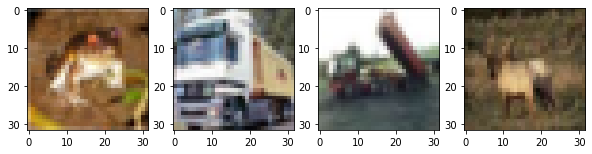

In [2]:
def show_images(datset, num_samples=4, cols=4):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.CIFAR10(root="C:/Users/BMSSA_16/Desktop/Itnl_Study/datasets", download=True)
show_images(data)

In [3]:
IMG_SIZE = 64
BATCH_SIZE = 8

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 2) - 1)
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.CIFAR10(root="C:/Users/BMSSA_16/Desktop/Itnl_Study/datasets", train=True, download=True, transform=data_transform)

    test = torchvision.datasets.CIFAR10(root="C:/Users/BMSSA_16/Desktop/Itnl_Study/datasets", train=False, download=True, transform=data_transform)
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def prepare_noise_schedule(noise_steps, beta_start=0.00001, beta_end=0.02):
        return torch.linspace(beta_start, beta_end, noise_steps)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
T = 50  # 전체 타임스텝 설정
beta = prepare_noise_schedule(noise_steps=T).to(device)
alpha = 1. - beta
alpha_hat = torch.cumprod(alpha, axis=0)

# Forward Samples

In [6]:
def cosine_beta_schedule(timesteps, s=0.00001, device=torch.device('cpu')):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, device=device)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

In [9]:
def linear_beta_schedule(timesteps, start = 0.00001, end = 0.02, device=torch.device('cpu')):
    return torch.linspace(start, end, timesteps)

In [12]:
def quadrratic_beta_schedule(timesteps, start = 0.00001, end = 0.02, device=torch.device('cpu')):
    return torch.linspace(start ** 0.5, end ** 0.5, timesteps) ** 2

# -------------------------------------------------------------------------------------------------

In [13]:
def forward_diffusion_sample(x, t, betas, device=torch.device('cpu')):
    noise = torch.randn_like(x, device=device)  # device 추가
    alpha = 1.0 - betas[t]  # t에 해당하는 베타 값 사용
    alpha_hat = torch.cumprod(torch.tensor([alpha], device=device), dim=0)  # device 추가

    sqrt_alpha_hat = torch.sqrt(alpha_hat)[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat)[:, None, None, None]

    # 노이즈와 결합된 이미지 반환
    return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise, noise

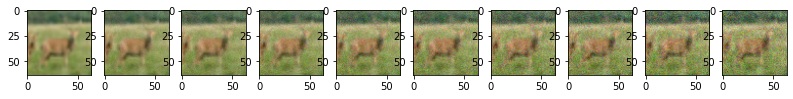

In [14]:
image = next(iter(dataloader))[0].to(device)  # 이미지를 바로 GPU로 이동

# 그래프 설정
plt.figure(figsize=(15, 15))
plt.axis('off')

# 이미지 수와 스텝 사이즈 설정
num_images = 10

stepsize = int(T / num_images)

# 베타 값 생성
betas = linear_beta_schedule(T).to(device)  # 베타 값을 GPU로 이동

# 초기 이미지 설정
x = image  # 이미지 이미 GPU에 있음

# 순차적으로 이미지에 노이즈 추가
for idx in range(0, T, stepsize):
    t = torch.tensor([idx], device=device)  # 현재 타임스텝 설정, 바로 GPU에 생성

    # forward_diffusion_sample로 노이즈 샘플링
    noisy_image, noise = forward_diffusion_sample(x, t, betas, device=device)
    
    # 이미지 시각화
    plt.subplot(1, num_images + 1, idx // stepsize + 1)
    show_tensor_image(noisy_image.cpu())  # 이미지를 CPU로 이동하여 시각화

plt.show()